# Backup Frequencies

Large trucks make a beeping noise when backing up to safely warn pedestrians of an approaching vehicle.

Let's try to figure out what the frequencies are, and then make a best-effort to reproduce the sound.


In [286]:
import warnings
warnings.filterwarnings('ignore')


### Loading audio


In [287]:
import librosa
audio_path = './input/backing-up-scania-r580.wav'
x, sr = librosa.load(audio_path)

print(sr)
# Audio clip length
len(x)/sr


22050


3.0

### Playing audio


In [288]:
import IPython.display as ipd
ipd.Audio(audio_path)


## Waveform


(66150,)


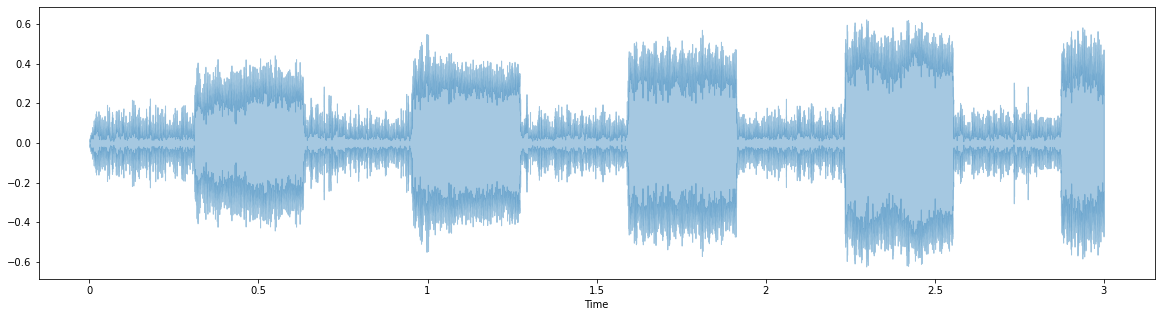

In [289]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(20, 5))
print(x.shape)
librosa.display.waveshow(x, sr=sr, alpha=0.4)


## Spectrogram

Let's display the spectrogram of this clip and pick a window to analyze


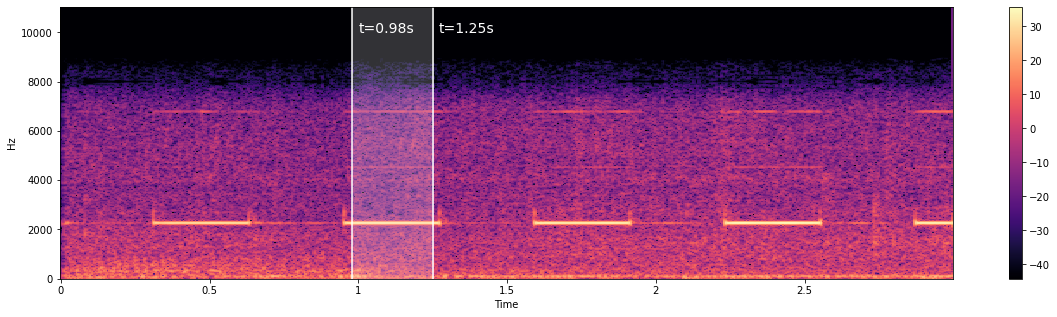

In [290]:
import numpy as np

# Reduce window length to be able to find narrowband signals
n_fft = 2048
win_length = n_fft // 4
hop_length = win_length // 4

# Calculate FFT in dB
X = librosa.stft(x, n_fft=n_fft, win_length=win_length, hop_length=hop_length)
Xdb = librosa.amplitude_to_db(abs(X))

# Plot Spectrogram
plt.figure(figsize=(20, 5))
librosa.display.specshow(Xdb, n_fft=n_fft, win_length=win_length,
                         hop_length=hop_length, x_axis='time', y_axis='hz', cmap="magma")
plt.colorbar()


# Window to analyze
window_t = (0.98, 1.25)
plt.axvspan(xmin=window_t[0], xmax=window_t[1], color='w', alpha=0.2)

for time in window_t:
    plt.axvline(x=time, color='w')
    plt.text(x=time+.02, y=10000, s=f"t={time}s", color='w', size=14)


## Local Maxima

OK, it looks like we have a tone somewhere around 2200Hz (and 4400Hz/6600Hz). Let's plot the FFT frequency amplitudes of the above window and find local maxima.

<!-- We could probably build this tone and be done with it, but let's see if we can filter out the noise of the engine and get a better picture of what's going on.

https://www.kaggle.com/code/mauriciofigueiredo/methods-for-sound-noise-reduction/notebook -->


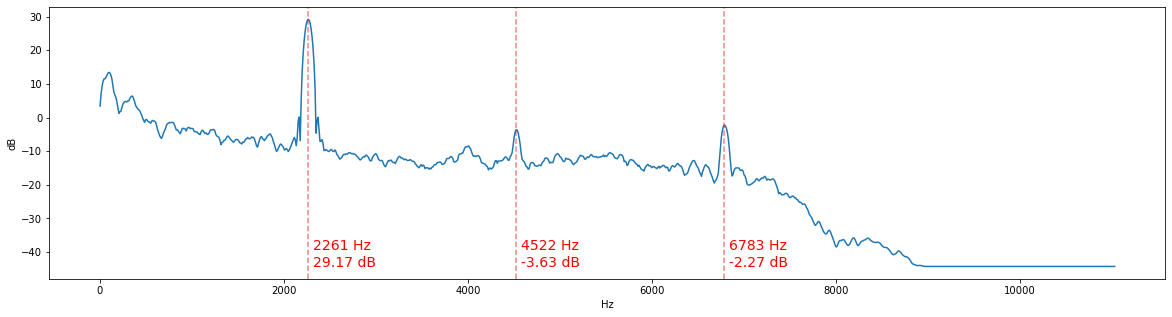

In [291]:
# https://stackoverflow.com/a/63351314/1130342
from scipy.signal import argrelextrema

# Windowed FFT averages
window_i = librosa.core.time_to_frames(
    [window_t[0], window_t[1]], sr=sr, n_fft=n_fft, hop_length=hop_length)
window_Xdb = Xdb[:, window_i[0]:window_i[1]]
average_Xdb = np.mean(window_Xdb, axis=1)

frequencies = librosa.core.fft_frequencies(sr=sr, n_fft=n_fft)

# Plot average frequency amplitudes across window
plt.figure(figsize=(20, 5))
plt.plot(frequencies, average_Xdb, )
plt.xlabel('Hz')
plt.ylabel('dB')


# Plot local maxima
local_maxima = argrelextrema(average_Xdb, np.greater, order=195)[0]
peaks = zip(frequencies[local_maxima], average_Xdb[local_maxima])


for f, a in peaks:
    plt.axvline(x=f, color='r', alpha=0.5, linestyle='--')
    plt.text(x=f+50, y=min(average_Xdb),
             s=f"{round(f)} Hz\n{a:.2f} dB", color='r', size=14)


OK, so we clearly have a tone with fundamental pitch of f=2261 Hz, and overtones of `f*2` and `f*3`. To keep the solution simple, we will reproduce the fundamental pitch.

## Replicating the Tone

Let's create a tone of 2261Hz and see how it sounds

TODO: calculate tone amplitude based on decibels

In [292]:
import numpy as np

# Best guess values
frequency_db_peaks = [(2261, 1), (4522, 0.03), (6783, 0.06)]

sr = 22050
T = 5.0
t = np.linspace(0, T, int(T*sr), endpoint=False)

x = 0
for f, a in frequency_db_peaks:
    x = x + a * np.sin(2*np.pi*f*t)

ipd.Audio(x, rate=sr)


### Writing the tone


In [293]:
import soundfile as sf
sf.write('./out/backing-up-scania-r580-synthetic.wav', x, sr, 'PCM_24')


## Replicating the Period

TODO: get the period from the original recording and replicate it
